# 1. Подготовка датасета

На данном этапе производится загрузка и предварительная обработка датасетов для задачи детекции фишинговых email сообщений. Используются два датасета:
- **Nazario Phishing Corpus** (2015-2024) - коллекция фишинговых писем
- **Enron Email Dataset** - коллекция легитимных писем

**Важно**: Парсинг email, извлечение признаков и другие операции выполняются через модули системы (`src/email_parser.py`, `src/feature_extractor.py` и т.д.). В данном блокноте выполняется только загрузка и подготовка сырых данных.




In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Добавляем родительскую директорию в sys.path для импорта модулей как пакета
# Это позволяет использовать относительные импорты в модулях (например, .utils)
BASE_DIR = Path('../').resolve()
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Настройка путей
DATA_RAW = BASE_DIR / 'data' / 'raw'
DATA_PROCESSED = BASE_DIR / 'data' / 'processed'

print(f"Рабочая директория: {BASE_DIR}")
print(f"Исходные данные: {DATA_RAW}")
print(f"Обработанные данные: {DATA_PROCESSED}")
print(f"sys.path содержит: {BASE_DIR}")


Рабочая директория: C:\Users\huzch\Documents\project\eml-phishing-analyzer
Исходные данные: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\raw
Обработанные данные: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\processed
sys.path содержит: C:\Users\huzch\Documents\project\eml-phishing-analyzer


## 2. Загрузка Nazario Phishing Corpus

Nazario Phishing Corpus представляет из себя отдельные файлы с письмами за период 2015-2024. Файлы представлены в текстовом формате, письма начинаются с "From " и разделены пустой строкой.

In [ ]:
def split_nazario_file(file_path: Path) -> list:
    """
    Разделяет файл Nazario на отдельные email сообщения.
    
    Args:
        file_path: Путь к файлу
        
    Returns:
        list: Список строк с содержимым каждого email
    """
    emails = []
    current_email = []
    
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            # Проверяем, начинается ли строка с "From " (начало нового письма)
            if line.startswith('From ') and len(line) > 20 and '@' in line:
                if current_email:
                    emails.append(''.join(current_email))
                current_email = [line]
            else:
                current_email.append(line)
        
        # Добавляем последнее письмо
        if current_email:
            emails.append(''.join(current_email))
    
    return emails


# Загрузка Nazario Phishing Corpus (2015-2024)
nazario_path = DATA_RAW / 'nazario'
nazario_files = sorted(nazario_path.glob('phishing-*.txt'))

print(f"Найдено файлов Nazario: {len(nazario_files)}")
for f in nazario_files:
    print(f"  - {f.name}")

# Объединение всех файлов
all_nazario_emails = []
for file_path in tqdm(nazario_files, desc="Загрузка Nazario файлов"):
    emails = split_nazario_file(file_path)
    all_nazario_emails.extend(emails)
    print(f"  {file_path.name}: {len(emails)} писем")

print(f"\nВсего загружено фишинговых писем: {len(all_nazario_emails)}")


Выведем несколько писем для проверки корректной обработки датасета.

In [ ]:
emails_nazario_example = all_nazario_emails[:5]
emails_nazario_example

### 2.1 Сохранение Nazario датасета

После загрузки Nazario датасет сохраняется в структурированном формате (CSV) для дальнейшей обработки.


In [ ]:
# Сохранение в DataFrame для дальнейшей обработки
print("Создание DataFrame для Nazario датасета...")
df_nazario = pd.DataFrame({
    'email_content': all_nazario_emails,
    'label': 1 # фишинговое письмо
})


In [ ]:
df_nazario.head()

In [ ]:
print(f"Размер датасета Nazario: {len(df_nazario)}")
print(f"Распределение меток: {df_nazario['label'].value_counts().to_dict()}")

In [ ]:
# Сохранение Nazario в CSV
print("\nСохранение Nazario датасета в CSV...")
nazario_csv_path = DATA_PROCESSED / 'nazario_raw.csv'
with tqdm(total=1, desc="Сохранение файла", unit="файл", 
          colour='#A23B72', ncols=100, 
          bar_format='{l_bar}{bar}| {elapsed}<{remaining}') as pbar:
    df_nazario.to_csv(nazario_csv_path, index=False)
    pbar.update(1)

print(f"Nazario датасет сохранен: {nazario_csv_path}")

## 3. Загрузка Enron Email Dataset

Enron Email Dataset содержит легитимные письма. Файл представлен в формате CSV. После загрузки будет выполнено сравнение размеров с Nazario датасетом и балансировка при необходимости.


In [ ]:
# Определение структуры Enron файла
enron_path = DATA_RAW / 'enron' / 'emails.csv'

# Читаем первые строки для понимания структуры
sample_df = pd.read_csv(enron_path).head()
print(f"Столбцы Enron: {sample_df.columns.tolist()}")
print(f"\nПример данных:")
print(sample_df)

# Определяем столбец с содержимым email
email_content_col = 'message'
print(f"\nИспользуется столбец: {email_content_col}")


In [ ]:
# Загрузка Enron (по частям из-за большого размера)
chunk_size = 10000
enron_data = []

# Загружаем все доступные данные 
for chunk in tqdm(pd.read_csv(enron_path, chunksize=chunk_size), desc="Чтение Enron"):
    # Берем только нужный столбец
    chunk_emails = chunk[[email_content_col]].copy()
    chunk_emails.columns = ['email_content']
    enron_data.append(chunk_emails)

df_enron_raw = pd.concat(enron_data, ignore_index=True)

print(f"\nЗагружено легитимных писем: {len(df_enron_raw)}")


In [ ]:
# Уменьшение размера Enron до 2950 строк для балансировки
import random
target_size = 2950
print(f"Уменьшение размера Enron с {len(df_enron_raw)} до {target_size} строк...")
random.seed(42)
df_enron_raw = df_enron_raw.sample(n=target_size, random_state=42).reset_index(drop=True)
print(f"Размер после уменьшения: {len(df_enron_raw)}")


### 3.1 Сохранение Enron датасета

После загрузки Enron датасет сохраняется в структурированном формате (CSV) для дальнейшей обработки.


In [ ]:
# Сохранение в DataFrame для дальнейшей обработки
print("Создание DataFrame для Enron датасета...")
df_enron = pd.DataFrame({
    'email_content': df_enron_raw['email_content'],
    'label': 0  # легитимное письмо
})

In [ ]:
df_enron.head()


In [ ]:
print(f"Размер датасета Enron: {len(df_enron)}")
print(f"Распределение меток: {df_enron['label'].value_counts().to_dict()}")


In [ ]:
# Сохранение Enron в CSV
print("\nСохранение Enron датасета в CSV...")
enron_csv_path = DATA_PROCESSED / 'enron_raw.csv'
with tqdm(total=1, desc="Сохранение файла", unit="файл", 
          colour='#A23B72', ncols=100, 
          bar_format='{l_bar}{bar}| {elapsed}<{remaining}') as pbar:
    df_enron.to_csv(enron_csv_path, index=False)
    pbar.update(1)

print(f"Enron датасет сохранен: {enron_csv_path}")

In [ ]:
# Сравнение размеров датасетов
nazario_size = len(df_nazario)
enron_size = len(df_enron)

print(f"Размер Nazario (phishing): {nazario_size}")
print(f"Размер Enron (legitimate): {enron_size}")
print(f"Разница: {abs(nazario_size - enron_size)}")

# Балансировка: привести оба датасета к минимальному размеру
min_size = min(nazario_size, enron_size)
if nazario_size != enron_size:
    print(f"\nБалансировка датасетов до минимального размера ({min_size})...")
    df_nazario = df_nazario.sample(n=min_size, random_state=42).reset_index(drop=True)
    df_enron = df_enron.sample(n=min_size, random_state=42).reset_index(drop=True)
    print(f"Размер Nazario после балансировки: {len(df_nazario)}")
    print(f"Размер Enron после балансировки: {len(df_enron)}")
else:
    print("\nРазмеры датасетов уже сбалансированы.")

print(f"\nФинальные размеры:")
print(f"  Nazario (phishing): {len(df_nazario)}")
print(f"  Enron (legitimate): {len(df_enron)}")


## 4. Объединение датасетов

Объединение фишинговых и легитимных писем в единый датасет для дальнейшей обработки модулями системы.


In [ ]:
# Объединение Nazario и Enron в общий датафрейм
df = pd.concat([df_nazario, df_enron], ignore_index=True)

### 4.1 Проверка и очистка данных

In [2]:
df = pd.read_csv(DATA_PROCESSED / 'email_dataset.csv')

In [3]:

# Подсчёт количества пустых значений и дублей до очистки
num_na = df['email_content'].isnull().sum()
num_dupes = df.duplicated().sum()
print(f"Пустых email_content: {num_na}")
print(f"Дубликатов: {num_dupes}")

# Очистка: удаляем пустые и дубликаты
df = df.dropna(subset=['email_content']).drop_duplicates().reset_index(drop=True)

print(f"Размер после очистки: {df.shape}")

print("\nФинальное распределение классов:")
print(df['label'].value_counts())

Пустых email_content: 0
Дубликатов: 0
Размер после очистки: (5900, 2)

Финальное распределение классов:
label
1    2950
0    2950
Name: count, dtype: int64


In [4]:
df.head()

,email_content,label
0,From jose@monkey.org Thu Aug 17 11:41:23 2023 ...,1
1,From jose@monkey.org Fri Sep 27 15:46:37 2024 ...,1
2,From jose@monkey.org Mon Apr 20 11:26:14 2020 ...,1
3,From jose@monkey.org Thu Sep 21 19:14:02 2017 ...,1
4,From jose@monkey.org Wed May 3 17:20:00 2017 ...,1


In [5]:
df.tail()

,email_content,label
5895,Message-ID: <17702800.1075856096893.JavaMail.e...,0
5896,Message-ID: <16654602.1075840221753.JavaMail.e...,0
5897,Message-ID: <21859410.1075852282055.JavaMail.e...,0
5898,Message-ID: <11613616.1075849659137.JavaMail.e...,0
5899,Message-ID: <19463108.1075852096010.JavaMail.e...,0


In [6]:
# Сохранение итогового датасета
output_path = DATA_PROCESSED / 'email_dataset.csv'
df.to_csv(output_path, index=False)
print(f"Итоговый датасет сохранён в {output_path}")

Итоговый датасет сохранён в C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\processed\email_dataset.csv


In [7]:
# Подсчёт количества пустых значений и дублей до очистки
num_na = df['email_content'].isnull().sum()
num_dupes = df.duplicated().sum()
print(f"Пустых строк: {num_na}")
print(f"Дубликатов: {num_dupes}")


print("Размерность после очистки:", df.shape)


Пустых строк: 0
Дубликатов: 0
Размерность после очистки: (5900, 2)


## 5. Парсинг email сообщений

На данном этапе производится парсинг каждого email сообщения с использованием модуля `email_parser`. 
Извлекаются заголовки, тело письма, вложения, URL и домены.


In [8]:
# Импорт модулей для обработки
# Родительская директория добавлена в sys.path, поэтому src доступен как пакет
import importlib
from src.email_parser import parse_email
from src.translation import Translator
from src.url_domain_analyzer import analyze_urls_and_domains

# Импорт и перезагрузка модуля translation для применения последних изменений
import src.translation as translation_module
importlib.reload(translation_module)
from src.translation import Translator

# Импорт и перезагрузка модуля feature_extractor для применения последних изменений
import src.feature_extractor as fe_module
importlib.reload(fe_module)
from src.feature_extractor import FeatureExtractor

import pickle
from sklearn.model_selection import train_test_split

# Инициализация компонентов
translator = Translator()
feature_extractor = FeatureExtractor(max_features=5000)


In [9]:
# Парсинг всех email сообщений
print("Начало парсинга email сообщений...")
parsed_emails = []
invalid_indices = []  # Индексы писем с ошибками парсинга 
initial_count = len(df)

for idx, email_content in tqdm(enumerate(df['email_content']), total=len(df), desc="Парсинг писем"):
    try:
        parsed = parse_email(str(email_content))
        parsed_emails.append(parsed)
    except Exception as e:
        # В случае ошибки парсинга сохраняем индекс для удаления
        invalid_indices.append(idx)
        print(f"Ошибка парсинга письма {idx}: {str(e)[:100]}... Письмо будет удалено из датасета.")

# Удаляем письма с ошибками парсинга из датасета 
if invalid_indices:
    df = df.drop(df.index[invalid_indices]).reset_index(drop=True)

print(f"\nПарсинг завершен. Успешно обработано писем: {len(parsed_emails)}")
print(f"Удалено писем с ошибками: {len(invalid_indices)} ({len(invalid_indices)/initial_count*100:.2f}%)")


Начало парсинга email сообщений...


Парсинг писем:  11%|█         | 642/5900 [00:14<01:49, 47.93it/s]

Ошибка парсинга письма 638: unknown encoding: utf-8message-id: <1571316602-94a08da1fecbb6e8b46990538c7b50b2-94a08da1fecbb6e8b469... Письмо будет удалено из датасета.


Парсинг писем:  42%|████▏     | 2453/5900 [01:24<01:26, 39.97it/s]

Ошибка парсинга письма 2444: unknown encoding: utf-8x-priority: 3... Письмо будет удалено из датасета.


Парсинг писем: 100%|██████████| 5900/5900 [02:46<00:00, 35.53it/s]


Парсинг завершен. Успешно обработано писем: 5898
Удалено писем с ошибками: 2 (0.03%)


## 6. Перевод текста писем

Перевод русскоязычных писем на английский язык для единообразной обработки. 
Англоязычные письма остаются без изменений.


In [10]:
# Перевод всех писем
print("Начало перевода писем...")
translated_texts = []
translated_count = 0  # Счетчик переведенных писем

# Определяем метод подготовки текста (можно вызывать через класс или экземпляр)
if hasattr(FeatureExtractor, 'prepare_text_from_parsed_email'):
    prepare_text_func = FeatureExtractor.prepare_text_from_parsed_email
elif hasattr(feature_extractor, 'prepare_text_from_parsed_email'):
    prepare_text_func = feature_extractor.prepare_text_from_parsed_email
else:
    raise AttributeError("Метод prepare_text_from_parsed_email не найден. "
                        "Убедитесь, что модуль feature_extractor перезагружен.")

for parsed_email in tqdm(parsed_emails, desc="Перевод писем"):
    try:
        # Подготовка текста: очистка HTML и объединение subject + body
        clean_text = prepare_text_func(parsed_email)
        
        # Определяем язык
        detected_language = translator.detect_language(clean_text) if clean_text else 'en'
        
        # Переводим письмо (только перевод, без очистки HTML)
        translated = translator.translate_text(clean_text)
        
        # Считаем только если язык был русский
        if detected_language == 'ru':
            translated_count += 1
        
        translated_texts.append(translated)
    except Exception as e:
        # В случае ошибки перевода используем оригинальный текст (подготовленный)
        print(f"Ошибка перевода: {e}")
        try:
            # Пытаемся подготовить текст еще раз
            clean_text = prepare_text_func(parsed_email)
            translated_texts.append(clean_text)
        except Exception as e2:
            # Fallback: просто subject и body_plain без очистки HTML
            subject = parsed_email.get('subject', '') or ''
            body = parsed_email.get('body_plain', '') or ''
            if not body:
                body = parsed_email.get('body_html', '') or ''
            translated_texts.append(f"{subject} {body}".strip())

print(f"\nПеревод завершен. Обработано писем: {len(translated_texts)}")
print(f"Действительно переведено с русского на английский: {translated_count}")
print(f"Писем на английском (не требовали перевода): {len(translated_texts) - translated_count}")


Начало перевода писем...


Перевод писем: 100%|██████████| 5898/5898 [01:45<00:00, 56.14it/s]


Перевод завершен. Обработано писем: 5898
Действительно переведено с русского на английский: 1
Писем на английском (не требовали перевода): 5897


## 7. Анализ URL и доменов

Анализ URL-адресов и доменов для выявления подозрительных паттернов:
- URL-shorteners
- Длинные домены
- Подозрительные TLD
- IP-адреса в URL


In [11]:
# Анализ URL и доменов для каждого письма
print("Начало анализа URL и доменов...")
url_analyses = []

for parsed_email in tqdm(parsed_emails, desc="Анализ URL/доменов"):
    try:
        analysis = analyze_urls_and_domains(parsed_email)
        url_analyses.append(analysis)
    except Exception as e:
        # В случае ошибки создаем пустой анализ
        print(f"Ошибка анализа URL/доменов: {e}")
        url_analyses.append({
            'has_url_shortener': False,
            'has_long_domain': False,
            'has_suspicious_tld': False,
            'has_ip_in_url': False
        })

print(f"\nАнализ URL/доменов завершен. Обработано: {len(url_analyses)}")


Начало анализа URL и доменов...


Анализ URL/доменов: 100%|██████████| 5898/5898 [00:00<00:00, 11980.21it/s]


Анализ URL/доменов завершен. Обработано: 5898


## 8. Извлечение признаков

На данном этапе производится:
1. Обучение TF-IDF векторизатора на всех переведенных текстах
2. Извлечение синтетических признаков для каждого письма
3. Объединение TF-IDF векторов и синтетических признаков в финальные feature vectors


### 8.2 Создание датафрейма с признаками

Перед векторизацией создаем датафрейм со всеми признаками, которые будут использоваться для машинного обучения.


In [12]:
# Создание датафрейма со всеми признаками перед векторизацией
print("Создание датафрейма с признаками...")

features_data = []

for idx, (parsed_email, translated_text, url_analysis) in enumerate(tqdm(
    zip(parsed_emails, translated_texts, url_analyses),
    total=len(parsed_emails),
    desc="Сбор признаков для датафрейма"
)):
    try:
        # Извлечение всех признаков
        quantitative_norm, quantitative_raw = feature_extractor.extract_quantitative_features(parsed_email)
        structural_norm, structural_raw = feature_extractor.extract_structural_features(parsed_email)
        binary = feature_extractor.extract_binary_indicators(url_analysis)
        linguistic_norm, linguistic_raw = feature_extractor.extract_linguistic_features(translated_text)
        
        # Предобработка текста (та же, что используется для векторизации)
        preprocessed_text = feature_extractor.preprocess_text(translated_text)
        
        features_data.append({
            'email_content': df.iloc[idx]['email_content'][:100] + '...' if len(df.iloc[idx]['email_content']) > 100 else df.iloc[idx]['email_content'],
            'preprocessed_text': preprocessed_text,
            'body_length': int(structural_raw[1]),
            'subject_length': int(structural_raw[0]),
            'url_count': int(quantitative_raw[0]),
            'attachment_count': int(quantitative_raw[1]),
            'ip_count': int(quantitative_raw[2]),
            'has_url_shortener': int(binary[0]),
            'has_long_domain': int(binary[1]),
            'has_suspicious_tld': int(binary[2]),
            'has_ip_in_url': int(binary[3]),
            'urgency_markers_count': int(linguistic_raw[0]),
            'label': df.iloc[idx]['label']
        })
    except Exception as e:
        print(f"Ошибка сбора признаков для письма {idx}: {e}")
        # В случае ошибки пытаемся предобработать текст, если возможно
        try:
            preprocessed_text = feature_extractor.preprocess_text(translated_text) if translated_text else ''
        except:
            preprocessed_text = ''
        
        features_data.append({
            'email_content': df.iloc[idx]['email_content'][:100] + '...' if len(df.iloc[idx]['email_content']) > 100 else df.iloc[idx]['email_content'],
            'preprocessed_text': preprocessed_text,
            'body_length': 0,
            'subject_length': 0,
            'url_count': 0,
            'attachment_count': 0,
            'ip_count': 0,
            'has_url_shortener': 0,
            'has_long_domain': 0,
            'has_suspicious_tld': 0,
            'has_ip_in_url': 0,
            'urgency_markers_count': 0,
            'label': df.iloc[idx]['label']
        })

# Создание датафрейма
df_features = pd.DataFrame(features_data)

print(f"\nДатафрейм с признаками создан. Размер: {df_features.shape}")
print("\nПервые 10 строк датафрейма:")
display(df_features.head(10))


Создание датафрейма с признаками...


Сбор признаков для датафрейма:   0%|          | 0/5898 [00:00<?, ?it/s]

Ошибка сбора признаков для письма 0: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'


Сбор признаков для датафрейма:   1%|          | 45/5898 [00:01<02:54, 33.50it/s] 

Ошибка сбора признаков для письма 1: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 6: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 7: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 8: Feat

Сбор признаков для датафрейма:   2%|▏         | 141/5898 [00:02<00:47, 121.71it/s]

Ошибка сбора признаков для письма 96: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 97: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 98: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 99: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 100: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 101: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 102: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для пись

Сбор признаков для датафрейма:   4%|▍         | 225/5898 [00:02<00:28, 201.54it/s]

Ошибка сбора признаков для письма 182: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 183: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 184: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 185: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 186: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 187: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 188: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:   6%|▌         | 368/5898 [00:02<00:16, 325.60it/s]

Ошибка сбора признаков для письма 277: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 278: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 279: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 280: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 281: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 282: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 283: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:   7%|▋         | 410/5898 [00:02<00:15, 345.28it/s]

Ошибка сбора признаков для письма 368: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 369: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 370: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 371: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 372: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 373: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 374: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:   8%|▊         | 492/5898 [00:02<00:15, 347.66it/s]

Ошибка сбора признаков для письма 444: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 445: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 446: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 447: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 448: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 449: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 450: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:  11%|█         | 627/5898 [00:03<00:13, 391.67it/s]

Ошибка сбора признаков для письма 535: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 536: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 537: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 538: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 539: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 540: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 541: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:  11%|█▏        | 672/5898 [00:03<00:13, 398.75it/s]

Ошибка сбора признаков для письма 627: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 628: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 629: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 630: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 631: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 632: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 633: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:  13%|█▎        | 753/5898 [00:03<00:13, 368.24it/s]

Ошибка сбора признаков для письма 702: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 703: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 704: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 705: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 706: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 707: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 708: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:  14%|█▍        | 833/5898 [00:03<00:13, 369.70it/s]

Ошибка сбора признаков для письма 777: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 778: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 779: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 780: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 781: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 782: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 783: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:  16%|█▌        | 927/5898 [00:04<00:12, 398.46it/s]

Ошибка сбора признаков для письма 886: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 887: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 888: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 889: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 890: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 891: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 892: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:  17%|█▋        | 1008/5898 [00:04<00:12, 385.96it/s]

Ошибка сбора признаков для письма 961: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 962: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 963: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 964: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 965: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 966: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 967: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для 

Сбор признаков для датафрейма:  19%|█▊        | 1099/5898 [00:04<00:11, 399.94it/s]

Ошибка сбора признаков для письма 1054: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1055: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1056: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1057: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1058: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1059: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1060: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  19%|█▉        | 1140/5898 [00:04<00:12, 389.85it/s]

Ошибка сбора признаков для письма 1130: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1131: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1132: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1133: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1134: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1135: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1136: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  20%|██        | 1209/5898 [00:06<00:46, 101.47it/s]

Ошибка сбора признаков для письма 1157: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1158: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1159: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1160: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1161: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1162: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1163: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  21%|██        | 1253/5898 [00:06<00:34, 134.92it/s]

Ошибка сбора признаков для письма 1209: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1210: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1211: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1212: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1213: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1214: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1215: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  22%|██▏       | 1320/5898 [00:06<00:25, 178.76it/s]

Ошибка сбора признаков для письма 1287: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1288: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1289: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1290: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1291: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1292: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1293: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  24%|██▍       | 1427/5898 [00:06<00:18, 246.70it/s]

Ошибка сбора признаков для письма 1360: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1361: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1362: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1363: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1364: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1365: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1366: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  25%|██▌       | 1497/5898 [00:07<00:16, 268.68it/s]

Ошибка сбора признаков для письма 1449: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1450: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1451: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1452: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1453: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1454: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1455: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  27%|██▋       | 1575/5898 [00:07<00:13, 313.63it/s]

Ошибка сбора признаков для письма 1531: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1532: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1533: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1534: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1535: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1536: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1537: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  29%|██▉       | 1707/5898 [00:07<00:11, 371.17it/s]

Ошибка сбора признаков для письма 1619: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1620: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1621: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1622: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1623: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1624: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1625: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  30%|███       | 1788/5898 [00:07<00:11, 373.24it/s]

Ошибка сбора признаков для письма 1707: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1708: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1709: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1710: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1711: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1712: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1713: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  31%|███       | 1829/5898 [00:07<00:10, 372.93it/s]

Ошибка сбора признаков для письма 1788: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1789: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1790: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1791: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1792: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1793: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1794: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  32%|███▏      | 1904/5898 [00:08<00:11, 336.87it/s]

Ошибка сбора признаков для письма 1865: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1866: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1867: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1868: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1869: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1870: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1871: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  33%|███▎      | 1974/5898 [00:08<00:12, 318.59it/s]

Ошибка сбора признаков для письма 1919: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1920: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1921: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1922: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1923: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1924: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 1925: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  35%|███▍      | 2039/5898 [00:08<00:12, 306.35it/s]

Ошибка сбора признаков для письма 2004: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2005: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2006: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2007: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2008: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2009: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2010: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  36%|███▌      | 2124/5898 [00:08<00:10, 358.87it/s]

Ошибка сбора признаков для письма 2070: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2071: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2072: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2073: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2074: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2075: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2076: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  37%|███▋      | 2207/5898 [00:09<00:10, 364.72it/s]

Ошибка сбора признаков для письма 2166: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2167: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2168: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2169: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2170: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2171: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2172: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  39%|███▉      | 2297/5898 [00:09<00:09, 389.55it/s]

Ошибка сбора признаков для письма 2245: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2246: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2247: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2248: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2249: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2250: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2251: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  40%|████      | 2381/5898 [00:09<00:09, 353.40it/s]

Ошибка сбора признаков для письма 2341: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2342: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2343: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2344: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2345: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2346: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2347: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  42%|████▏     | 2453/5898 [00:09<00:10, 333.47it/s]

Ошибка сбора признаков для письма 2409: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2410: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2411: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2412: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2413: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2414: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2415: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  43%|████▎     | 2549/5898 [00:09<00:08, 384.94it/s]

Ошибка сбора признаков для письма 2501: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2502: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2503: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2504: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2505: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2506: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2507: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  45%|████▍     | 2626/5898 [00:10<00:08, 365.49it/s]

Ошибка сбора признаков для письма 2585: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2586: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2587: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2588: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2589: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2590: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2591: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  47%|████▋     | 2761/5898 [00:10<00:07, 393.14it/s]

Ошибка сбора признаков для письма 2670: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2671: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2672: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2673: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2674: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2675: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2676: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  47%|████▋     | 2801/5898 [00:10<00:08, 384.76it/s]

Ошибка сбора признаков для письма 2761: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2762: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2763: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2764: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2765: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2766: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2767: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  49%|████▉     | 2918/5898 [00:10<00:08, 354.71it/s]

Ошибка сбора признаков для письма 2842: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2843: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2844: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2845: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2846: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2847: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2848: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  51%|█████     | 3000/5898 [00:11<00:07, 363.92it/s]

Ошибка сбора признаков для письма 2918: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2919: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2920: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2921: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2922: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2923: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 2924: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  52%|█████▏    | 3074/5898 [00:11<00:08, 335.07it/s]

Ошибка сбора признаков для письма 3017: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3018: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3019: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3020: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3021: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3022: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3023: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  53%|█████▎    | 3146/5898 [00:11<00:12, 215.16it/s]

Ошибка сбора признаков для письма 3088: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3089: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3090: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3091: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3092: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3093: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3094: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  54%|█████▍    | 3185/5898 [00:12<00:11, 244.81it/s]

Ошибка сбора признаков для письма 3161: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3162: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3163: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3164: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3165: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3166: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3167: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  55%|█████▌    | 3254/5898 [00:12<00:13, 202.13it/s]

Ошибка сбора признаков для письма 3195: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3196: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3197: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3198: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3199: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3200: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3201: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  56%|█████▌    | 3308/5898 [00:12<00:12, 209.40it/s]

Ошибка сбора признаков для письма 3254: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3255: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3256: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3257: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3258: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3259: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3260: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  57%|█████▋    | 3333/5898 [00:12<00:12, 206.99it/s]

Ошибка сбора признаков для письма 3308: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3309: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3310: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3311: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3312: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3313: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3314: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  57%|█████▋    | 3391/5898 [00:13<00:11, 213.55it/s]

Ошибка сбора признаков для письма 3365: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3366: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3367: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3368: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3369: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3370: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3371: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  59%|█████▊    | 3451/5898 [00:13<00:10, 238.75it/s]

Ошибка сбора признаков для письма 3423: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3424: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3425: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3426: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3427: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3428: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3429: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  59%|█████▉    | 3502/5898 [00:13<00:10, 236.79it/s]

Ошибка сбора признаков для письма 3477: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3478: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3479: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3480: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3481: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3482: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3483: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  60%|█████▉    | 3527/5898 [00:13<00:10, 225.21it/s]

Ошибка сбора признаков для письма 3519: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3520: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3521: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3522: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3523: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3524: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3525: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  60%|██████    | 3550/5898 [00:14<00:18, 127.94it/s]

Ошибка сбора признаков для письма 3536: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3537: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3538: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3539: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3540: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3541: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3542: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  62%|██████▏   | 3650/5898 [00:14<00:10, 216.27it/s]

Ошибка сбора признаков для письма 3591: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3592: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3593: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3594: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3595: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3596: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3597: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  63%|██████▎   | 3688/5898 [00:14<00:08, 249.09it/s]

Ошибка сбора признаков для письма 3650: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3651: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3652: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3653: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3654: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3655: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3656: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  63%|██████▎   | 3745/5898 [00:14<00:08, 243.07it/s]

Ошибка сбора признаков для письма 3715: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3716: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3717: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3718: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3719: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3720: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3721: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  65%|██████▌   | 3837/5898 [00:15<00:07, 260.25it/s]

Ошибка сбора признаков для письма 3775: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3776: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3777: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3778: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3779: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3780: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3781: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  66%|██████▌   | 3905/5898 [00:15<00:06, 286.58it/s]

Ошибка сбора признаков для письма 3860: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3861: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3862: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3863: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3864: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3865: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3866: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  67%|██████▋   | 3980/5898 [00:15<00:06, 313.37it/s]

Ошибка сбора признаков для письма 3937: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3938: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3939: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3940: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3941: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3942: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 3943: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  70%|██████▉   | 4101/5898 [00:15<00:05, 354.81it/s]

Ошибка сбора признаков для письма 4020: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4021: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4022: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4023: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4024: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4025: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4026: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  70%|███████   | 4137/5898 [00:15<00:05, 319.49it/s]

Ошибка сбора признаков для письма 4107: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4108: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4109: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4110: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4111: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4112: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4113: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  71%|███████▏  | 4204/5898 [00:16<00:06, 273.11it/s]

Ошибка сбора признаков для письма 4147: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4148: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4149: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4150: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4151: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4152: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4153: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  72%|███████▏  | 4265/5898 [00:16<00:05, 276.03it/s]

Ошибка сбора признаков для письма 4209: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4210: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4211: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4212: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4213: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4214: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4215: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  73%|███████▎  | 4294/5898 [00:16<00:06, 263.30it/s]

Ошибка сбора признаков для письма 4268: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4269: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4270: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4271: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4272: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4273: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4274: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  74%|███████▍  | 4350/5898 [00:16<00:06, 246.78it/s]

Ошибка сбора признаков для письма 4321: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4322: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4323: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4324: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4325: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4326: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4327: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  75%|███████▌  | 4434/5898 [00:17<00:06, 239.64it/s]

Ошибка сбора признаков для письма 4381: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4382: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4383: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4384: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4385: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4386: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4387: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  76%|███████▌  | 4484/5898 [00:17<00:06, 217.51it/s]

Ошибка сбора признаков для письма 4442: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4443: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4444: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4445: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4446: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4447: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4448: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  78%|███████▊  | 4581/5898 [00:17<00:06, 206.01it/s]

Ошибка сбора признаков для письма 4513: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4514: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4515: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4516: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4517: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4518: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4519: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  79%|███████▉  | 4657/5898 [00:18<00:04, 252.82it/s]

Ошибка сбора признаков для письма 4596: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4597: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4598: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4599: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4600: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4601: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4602: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  80%|███████▉  | 4715/5898 [00:18<00:04, 238.35it/s]

Ошибка сбора признаков для письма 4675: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4676: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4677: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4678: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4679: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4680: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4681: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  81%|████████  | 4789/5898 [00:18<00:04, 236.49it/s]

Ошибка сбора признаков для письма 4747: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4748: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4749: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4750: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4751: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4752: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4753: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  83%|████████▎ | 4867/5898 [00:19<00:03, 281.95it/s]

Ошибка сбора признаков для письма 4814: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4815: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4816: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4817: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4818: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4819: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4820: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  84%|████████▍ | 4945/5898 [00:19<00:03, 303.15it/s]

Ошибка сбора признаков для письма 4912: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4913: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4914: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4915: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4916: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4917: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4918: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  85%|████████▍ | 5007/5898 [00:19<00:03, 281.36it/s]

Ошибка сбора признаков для письма 4975: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4976: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4977: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4978: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4979: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4980: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 4981: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  86%|████████▌ | 5065/5898 [00:19<00:03, 255.49it/s]

Ошибка сбора признаков для письма 5029: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5030: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5031: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5032: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5033: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5034: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5035: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  87%|████████▋ | 5124/5898 [00:20<00:03, 257.46it/s]

Ошибка сбора признаков для письма 5080: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5081: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5082: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5083: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5084: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5085: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5086: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  88%|████████▊ | 5175/5898 [00:20<00:03, 213.78it/s]

Ошибка сбора признаков для письма 5140: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5141: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5142: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5143: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5144: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5145: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5146: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  89%|████████▉ | 5254/5898 [00:20<00:02, 281.59it/s]

Ошибка сбора признаков для письма 5209: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5210: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5211: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5212: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5213: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5214: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5215: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  90%|█████████ | 5312/5898 [00:20<00:02, 222.52it/s]

Ошибка сбора признаков для письма 5276: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5277: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5278: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5279: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5280: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5281: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5282: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  91%|█████████ | 5356/5898 [00:21<00:03, 166.31it/s]

Ошибка сбора признаков для письма 5336: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5337: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5338: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5339: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5340: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5341: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5342: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  92%|█████████▏| 5444/5898 [00:21<00:01, 230.12it/s]

Ошибка сбора признаков для письма 5381: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5382: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5383: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5384: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5385: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5386: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5387: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  93%|█████████▎| 5498/5898 [00:21<00:01, 240.00it/s]

Ошибка сбора признаков для письма 5444: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5445: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5446: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5447: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5448: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5449: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5450: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  95%|█████████▍| 5574/5898 [00:22<00:01, 295.66it/s]

Ошибка сбора признаков для письма 5520: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5521: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5522: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5523: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5524: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5525: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5526: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  95%|█████████▌| 5605/5898 [00:22<00:01, 200.32it/s]

Ошибка сбора признаков для письма 5583: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5584: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5585: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5586: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5587: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5588: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5589: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  96%|█████████▌| 5670/5898 [00:22<00:00, 237.11it/s]

Ошибка сбора признаков для письма 5626: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5627: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5628: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5629: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5630: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5631: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5632: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  97%|█████████▋| 5724/5898 [00:22<00:00, 243.61it/s]

Ошибка сбора признаков для письма 5694: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5695: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5696: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5697: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5698: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5699: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5700: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  98%|█████████▊| 5786/5898 [00:22<00:00, 251.06it/s]

Ошибка сбора признаков для письма 5754: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5755: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5756: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5757: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5758: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5759: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5760: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма:  99%|█████████▉| 5867/5898 [00:23<00:00, 279.05it/s]

Ошибка сбора признаков для письма 5836: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5837: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5838: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5839: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5840: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5841: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5842: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

Сбор признаков для датафрейма: 100%|██████████| 5898/5898 [00:23<00:00, 252.50it/s]


Ошибка сбора признаков для письма 5889: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5890: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5891: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5892: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5893: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5894: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признаков для письма 5895: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка сбора признак

,email_content,preprocessed_text,body_length,subject_length,url_count,attachment_count,ip_count,has_url_shortener,has_long_domain,has_suspicious_tld,has_ip_in_url,urgency_markers_count,label
0,From jose@monkey.org Thu Aug 17 11:41:23 2023 ...,account policy important account notification ...,0,0,0,0,0,0,0,0,0,0,1
1,From jose@monkey.org Fri Sep 27 15:46:37 2024 ...,payment receipt please review attached payment...,0,0,0,0,0,0,0,0,0,0,1
2,From jose@monkey.org Mon Apr 20 11:26:14 2020 ...,nedbank current account statement click read n...,0,0,0,0,0,0,0,0,0,0,1
3,From jose@monkey.org Thu Sep 21 19:14:02 2017 ...,receipt apple receipt apple jose billed applei...,0,0,0,0,0,0,0,0,0,0,1
4,From jose@monkey.org Wed May 3 17:20:00 2017 ...,incoming fund transfer confirmation alert dear...,0,0,0,0,0,0,0,0,0,0,1
5,From jose@monkey.org Fri Nov 22 16:45:42 2024 ...,unusual login attempt jose unusual login attem...,0,0,0,0,0,0,0,0,0,0,1
6,From jose@monkey.org Mon Apr 11 12:43:36 2016 ...,password expire day please click link validate...,0,0,0,0,0,0,0,0,0,0,1
7,From jose@monkey.org Wed Nov 29 18:00:57 2023 ...,item shared banned access online due unauthori...,0,0,0,0,0,0,0,0,0,0,1
8,From jose@monkey.org Thu Feb 23 02:00:46 2017 ...,email blacklisted email blacklisted dear jose ...,0,0,0,0,0,0,0,0,0,0,1
9,From jose@monkey.org Thu Mar 23 09:22:25 2023 ...,spam sharepoint send file review approval plea...,0,0,0,0,0,0,0,0,0,0,1


In [13]:
# ============================================
# АНАЛИЗ ЧАСТОТЫ СЛОВ ПО КЛАССАМ: топовые для фишинга и для легита
# Используется предобработанный текст из df_features (та же предобработка, что и для векторизатора)
# ============================================
from collections import Counter

def analyze_top_words_by_class(preprocessed_phishing, preprocessed_legitimate, top_n=50, class_ratio=0.3, other_ratio=0.05):
    """
    Находит слова, характерные только для одного класса (фишинг или легит), и топовые слова в каждом классе.
    Использует уже предобработанные тексты из df_features (preprocessed_text).
    """
    # Разбиваем предобработанные тексты на слова (preprocessed_text уже содержит обработанные слова через пробелы)
    phishing_words = []
    for processed_text in preprocessed_phishing:
        if processed_text and isinstance(processed_text, str):
            phishing_words.extend(processed_text.split())
    
    legitimate_words = []
    for processed_text in preprocessed_legitimate:
        if processed_text and isinstance(processed_text, str):
            legitimate_words.extend(processed_text.split())
    
    phishing_freq = Counter(phishing_words)
    legitimate_freq = Counter(legitimate_words)
    
    n_phishing = len(preprocessed_phishing)
    n_legitimate = len(preprocessed_legitimate)
    
    print(f"\n📊 Анализ частоты слов (по предобработанным текстам из df_features)")
    print(f"Фишинговых писем: {n_phishing}")
    print(f"Легитимных писем: {n_legitimate}")
    
    phishing_specific = []
    legitimate_specific = []
    
    # Слова, специфичные для фишинга
    for word, count in phishing_freq.most_common(top_n * 2):  # Берем больше, чтобы учесть фильтрацию
        if len(word) < 3: continue
        phishing_ratio = count / n_phishing if n_phishing else 0
        legit_ratio = legitimate_freq.get(word, 0) / n_legitimate if n_legitimate else 0
        if phishing_ratio > class_ratio and legit_ratio < other_ratio:
            phishing_specific.append({
                'word': word,
                'phishing_ratio': phishing_ratio,
                'legitimate_ratio': legit_ratio,
                'phishing_count': count
            })
        if len(phishing_specific) >= top_n:
            break

    # Слова, специфичные для легитимных
    for word, count in legitimate_freq.most_common(top_n * 2):  # Берем больше, чтобы учесть фильтрацию
        if len(word) < 3: continue
        legit_ratio = count / n_legitimate if n_legitimate else 0
        phishing_ratio = phishing_freq.get(word, 0) / n_phishing if n_phishing else 0
        if legit_ratio > class_ratio and phishing_ratio < other_ratio:
            legitimate_specific.append({
                'word': word,
                'legitimate_ratio': legit_ratio,
                'phishing_ratio': phishing_ratio,
                'legitimate_count': count
            })
        if len(legitimate_specific) >= top_n:
            break

    phishing_df = pd.DataFrame(phishing_specific).sort_values('phishing_ratio', ascending=False)
    legitimate_df = pd.DataFrame(legitimate_specific).sort_values('legitimate_ratio', ascending=False)
    return phishing_df, legitimate_df, phishing_freq, legitimate_freq

# Разделение предобработанных текстов по классам из df_features
phishing_preprocessed = df_features[df_features['label'] == 1]['preprocessed_text'].tolist()
legitimate_preprocessed = df_features[df_features['label'] == 0]['preprocessed_text'].tolist()

# Анализ с использованием предобработанных текстов из df_features
phishing_df, legitimate_df, phishing_freq, legitimate_freq = analyze_top_words_by_class(
    phishing_preprocessed, legitimate_preprocessed, top_n=100)

print("\n🔍 Топ-20 подозрительных слов (только фишинг):")
display(phishing_df.head(20))

print("\n🔍 Топ-20 наиболее характерных для легитимных писем слов:")
display(legitimate_df.head(20))

# Топ-10 как рекомендации
if not phishing_df.empty:
    print("\n💡 Рекомендуемые для DATASET_ARTIFACTS — только для фишинга:")
    for word in phishing_df.head(10)['word'].values:
        print(f"  '{word}'")
if not legitimate_df.empty:
    print("\n💡 Рекомендуемые для DATASET_ARTIFACTS — только для легитимных:")
    for word in legitimate_df.head(10)['word'].values:
        print(f"  '{word}'")



📊 Анализ частоты слов (по предобработанным текстам из df_features)
Фишинговых писем: 2948
Легитимных писем: 2950

🔍 Топ-20 подозрительных слов (только фишинг):


,word,phishing_ratio,legitimate_ratio,phishing_count
0,jose,1.133311,0.014237,3341
1,usaa,0.654342,0.000000,1929
2,dear,0.629579,0.038983,1856
3,verify,0.368385,0.012203,1086
4,password,0.367707,0.046441,1084
5,mailbox,0.321574,0.010847,948



🔍 Топ-20 наиболее характерных для легитимных писем слов:


,word,legitimate_ratio,phishing_ratio,legitimate_count
0,enron,1.857627,0.000000,5480
1,ect,0.956949,0.002035,2823
2,power,0.755254,0.003731,2228
3,energy,0.747458,0.000339,2205
4,said,0.520000,0.004749,1534
5,market,0.487458,0.008480,1438
6,gas,0.443051,0.002714,1307
7,price,0.439661,0.012890,1297
8,state,0.398983,0.035617,1177
9,year,0.370169,0.028833,1092



💡 Рекомендуемые для DATASET_ARTIFACTS — только для фишинга:
  'jose'
  'usaa'
  'dear'
  'verify'
  'password'
  'mailbox'

💡 Рекомендуемые для DATASET_ARTIFACTS — только для легитимных:
  'enron'
  'ect'
  'power'
  'energy'
  'said'
  'market'
  'gas'
  'price'
  'state'
  'year'


In [14]:
# Обучение TF-IDF векторизатора на всех текстах
print("Обучение TF-IDF векторизатора...")
feature_extractor.fit_vectorizer(translated_texts)
print(f"TF-IDF векторизатор обучен. Размер словаря: {len(feature_extractor.tfidf_vectorizer.vocabulary_)}")


Обучение TF-IDF векторизатора...
TF-IDF векторизатор обучен. Размер словаря: 5000


In [15]:
# Извлечение синтетических признаков для обучения scaler
print("Извлечение синтетических признаков для обучения scaler...")
synthetic_features_list = []

for parsed_email, translated_text, url_analysis in tqdm(
    zip(parsed_emails, translated_texts, url_analyses), 
    total=len(parsed_emails),
    desc="Извлечение синтетических признаков"
):
    try:
        # Извлекаем синтетические признаки напрямую (до MinMax нормализации)
        quantitative_norm, _ = feature_extractor.extract_quantitative_features(parsed_email)
        structural_norm, _ = feature_extractor.extract_structural_features(parsed_email)
        binary = feature_extractor.extract_binary_indicators(url_analysis)
        linguistic_norm, _ = feature_extractor.extract_linguistic_features(translated_text)
        
        synthetic_features_array = np.concatenate([
            quantitative_norm, 
            structural_norm, 
            binary, 
            linguistic_norm
        ])
        synthetic_features_list.append(synthetic_features_array)
    except Exception as e:
        print(f"Ошибка извлечения признаков: {e}")
        # Создаем нулевой вектор синтетических признаков
        synthetic_features_list.append(np.zeros(10, dtype=np.float32))

# Обучение MinMaxScaler на синтетических признаках
feature_extractor.fit_scaler(synthetic_features_list)
print("MinMaxScaler для синтетических признаков обучен.")


Извлечение синтетических признаков для обучения scaler...


Извлечение синтетических признаков:  33%|███▎      | 1963/5898 [00:00<00:00, 18121.31it/s]

Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required posi

Извлечение синтетических признаков:  83%|████████▎ | 4886/5898 [00:00<00:00, 21553.43it/s]

Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required posi

Извлечение синтетических признаков: 100%|██████████| 5898/5898 [00:00<00:00, 20877.10it/s]

Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required positional argument: 'parsed_email'
Ошибка извлечения признаков: FeatureExtractor.extract_binary_indicators() missing 1 required posi

In [16]:
# Извлечение финальных feature vectors для всех писем
print("Извлечение финальных feature vectors...")
X_features = []
y_labels = []

for idx, (parsed_email, translated_text, url_analysis) in enumerate(tqdm(
    zip(parsed_emails, translated_texts, url_analyses),
    total=len(parsed_emails),
    desc="Создание feature vectors"
)):
    try:
        features = feature_extractor.extract_all_features(
            parsed_email,
            translated_text,
            url_analysis
        )
        X_features.append(features['feature_vector'])
        y_labels.append(df.iloc[idx]['label'])
    except Exception as e:
        print(f"Ошибка создания feature vector для письма {idx}: {e}")
        # Создаем нулевой вектор признаков
        X_features.append(np.zeros(feature_extractor.tfidf_vectorizer.max_features + 10, dtype=np.float32))
        y_labels.append(df.iloc[idx]['label'])

# Преобразование в numpy массивы
X = np.array(X_features)
y = np.array(y_labels)

print(f"\nFeature vectors созданы:")
print(f"  Размерность X: {X.shape}")
print(f"  Размерность y: {y.shape}")
print(f"  Распределение классов: {np.bincount(y)}")


Извлечение финальных feature vectors...


Создание feature vectors: 100%|██████████| 5898/5898 [00:53<00:00, 109.93it/s]


Feature vectors созданы:
  Размерность X: (5898, 5010)
  Размерность y: (5898,)
  Распределение классов: [2950 2948]


### 8.1 Проверка балансировки классов

Проверка соотношения legitimate/phishing классов в датасете.


Распределение классов:
  Legitimate (0): 2950 (50.02%)
  Phishing (1): 2948 (49.98%)


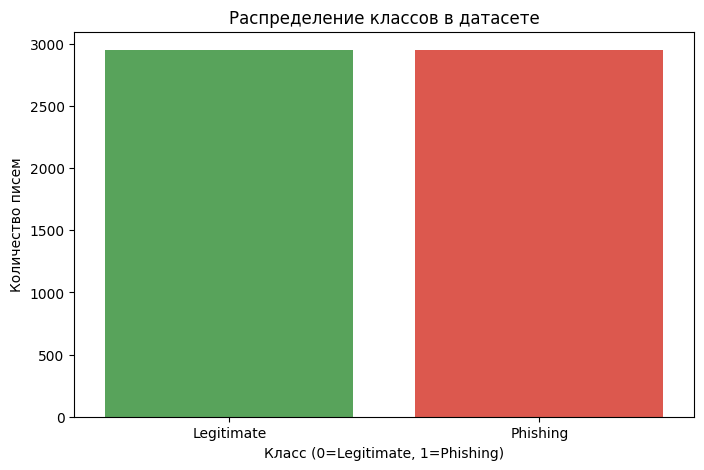


Классы сбалансированы.


In [17]:
# Проверка балансировки классов
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = pd.Series(y).value_counts()
class_percentages = pd.Series(y).value_counts(normalize=True) * 100

print("Распределение классов:")
print(f"  Legitimate (0): {class_counts.get(0, 0)} ({class_percentages.get(0, 0):.2f}%)")
print(f"  Phishing (1): {class_counts.get(1, 0)} ({class_percentages.get(1, 0):.2f}%)")

# Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette=['#4CAF50', '#F44336'])
plt.title('Распределение классов в датасете')
plt.xlabel('Класс (0=Legitimate, 1=Phishing)')
plt.ylabel('Количество писем')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.show()

# Если классы несбалансированы, можно применить балансировку
if abs(class_percentages.get(0, 0) - class_percentages.get(1, 0)) > 5:
    print("\n Классы несбалансированы. Рекомендуется балансировка.")
else:
    print("\nКлассы сбалансированы.")


## 9. Разделение данных на train/validation/test

Разделение датасета на три части:
- **70%** train — для обучения моделей
- **15%** validation — для подбора гиперпараметров
- **15%** test — для финальной оценки (резерв)

Используется стратифицированное разделение для сохранения пропорций классов.


In [18]:
# Разделение на train (70%) и временный набор (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Разделение временного набора на validation (15%) и test (15%)
# test_size = 0.5 означает, что из 30% мы берем 50%, т.е. 15% от исходного
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Разделение данных завершено:")
print(f"  Train:      {X_train.shape[0]} образцов ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]} образцов ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:       {X_test.shape[0]} образцов ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nРаспределение классов в train:")
print(f"  Legitimate: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Phishing:   {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\nРаспределение классов в validation:")
print(f"  Legitimate: {np.sum(y_val == 0)} ({np.sum(y_val == 0)/len(y_val)*100:.1f}%)")
print(f"  Phishing:   {np.sum(y_val == 1)} ({np.sum(y_val == 1)/len(y_val)*100:.1f}%)")

print(f"\nРаспределение классов в test:")
print(f"  Legitimate: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Phishing:   {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")


Разделение данных завершено:
  Train:      4128 образцов (70.0%)
  Validation: 885 образцов (15.0%)
  Test:       885 образцов (15.0%)

Распределение классов в train:
  Legitimate: 2065 (50.0%)
  Phishing:   2063 (50.0%)

Распределение классов в validation:
  Legitimate: 442 (49.9%)
  Phishing:   443 (50.1%)

Распределение классов в test:
  Legitimate: 443 (50.1%)
  Phishing:   442 (49.9%)


## 10. Сохранение обработанных данных

Сохранение разделенных данных и обученного векторизатора в pickle файлы для использования в `model_training.ipynb`.


In [19]:
# Создание директории для сохранения
MODELS_DIR = BASE_DIR / 'data' / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Сохранение train.pkl
print("Сохранение train.pkl...")
with open(MODELS_DIR / 'train.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'y_train': y_train
    }, f)
print(f"✓ train.pkl сохранен: {MODELS_DIR / 'train.pkl'}")

# Сохранение val.pkl
print("Сохранение val.pkl...")
with open(MODELS_DIR / 'val.pkl', 'wb') as f:
    pickle.dump({
        'X_val': X_val,
        'y_val': y_val
    }, f)
print(f"✓ val.pkl сохранен: {MODELS_DIR / 'val.pkl'}")

# Сохранение test.pkl
print("Сохранение test.pkl...")
with open(MODELS_DIR / 'test.pkl', 'wb') as f:
    pickle.dump({
        'X_test': X_test,
        'y_test': y_test
    }, f)
print(f"✓ test.pkl сохранен: {MODELS_DIR / 'test.pkl'}")

# Сохранение обученного TF-IDF векторизатора и scaler
print("Сохранение tfidf_vectorizer.pkl...")
feature_extractor.save_vectorizer(str(MODELS_DIR / 'tfidf_vectorizer.pkl'))
print(f"✓ tfidf_vectorizer.pkl сохранен: {MODELS_DIR / 'tfidf_vectorizer.pkl'}")

print("\nВсе файлы успешно сохранены!")


Сохранение train.pkl...
✓ train.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\train.pkl
Сохранение val.pkl...
✓ val.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\val.pkl
Сохранение test.pkl...
✓ test.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\test.pkl
Сохранение tfidf_vectorizer.pkl...
✓ tfidf_vectorizer.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\tfidf_vectorizer.pkl

Все файлы успешно сохранены!


In [20]:
MODELS_DIR = BASE_DIR / 'data' / 'models'

In [21]:
# Можно ли вывести параметры из сохранённых файлов? — Да! Пример ниже:
import pickle

# Загружаем tfidf_vectorizer и scaler из файла
with open(MODELS_DIR / 'tfidf_vectorizer.pkl', 'rb') as f:
    vect_data = pickle.load(f)

vectorizer = vect_data['vectorizer']
scaler = vect_data.get('scaler', None)

print("="*40)
print("Параметры tfidf_vectorizer (из файла):")
vocab_size = len(vectorizer.vocabulary_)
print(f"  Размер словаря: {vocab_size}")
print(f"  n_features: {vectorizer.max_features}")
print(f"  min_df: {vectorizer.min_df}")
print(f"  max_df: {vectorizer.max_df}")
print(f"  ngram_range: {vectorizer.ngram_range}")

# Аналогично, можно узнать размерность X_train, X_val, X_test из их файлов:
with open(MODELS_DIR / 'train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(MODELS_DIR / 'val.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open(MODELS_DIR / 'test.pkl', 'rb') as f:
    test_data = pickle.load(f)

print("\nРазмерности массивов/датасетов (из файлов):")
print(f"  X_train: {getattr(train_data['X_train'], 'shape', 'нет атрибута shape')}")
print(f"  y_train: {getattr(train_data['y_train'], 'shape', 'нет атрибута shape')}")
print(f"  X_val: {getattr(val_data['X_val'], 'shape', 'нет атрибута shape')}")
print(f"  y_val: {getattr(val_data['y_val'], 'shape', 'нет атрибута shape')}")
print(f"  X_test: {getattr(test_data['X_test'], 'shape', 'нет атрибута shape')}")
print(f"  y_test: {getattr(test_data['y_test'], 'shape', 'нет атрибута shape')}")
print("="*40)

Параметры tfidf_vectorizer (из файла):
  Размер словаря: 5000
  n_features: 5000
  min_df: 2
  max_df: 0.95
  ngram_range: (1, 2)

Размерности массивов/датасетов (из файлов):
  X_train: (4128, 5010)
  y_train: (4128,)
  X_val: (885, 5010)
  y_val: (885,)
  X_test: (885, 5010)
  y_test: (885,)


In [22]:
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

# Конвертация в sparse matrix
from scipy.sparse import csr_matrix

X_train = csr_matrix(X_train)
X_val = csr_matrix(X_val)
X_test = csr_matrix(X_test)

In [23]:
# Сохранение данных в sparse формате
print("Сохранение train.pkl (sparse format)...")
with open(MODELS_DIR / 'train.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'y_train': y_train
    }, f)
print(f"✓ train.pkl сохранен: {MODELS_DIR / 'train.pkl'}")

print("Сохранение val.pkl (sparse format)...")
with open(MODELS_DIR / 'val.pkl', 'wb') as f:
    pickle.dump({
        'X_val': X_val,
        'y_val': y_val
    }, f)
print(f"✓ val.pkl сохранен: {MODELS_DIR / 'val.pkl'}")

print("Сохранение test.pkl (sparse format)...")
with open(MODELS_DIR / 'test.pkl', 'wb') as f:
    pickle.dump({
        'X_test': X_test,
        'y_test': y_test
    }, f)
print(f"✓ test.pkl сохранен: {MODELS_DIR / 'test.pkl'}")

print("\nВсе файлы успешно сохранены в sparse формате")


Сохранение train.pkl (sparse format)...
✓ train.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\train.pkl
Сохранение val.pkl (sparse format)...
✓ val.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\val.pkl
Сохранение test.pkl (sparse format)...
✓ test.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\test.pkl

Все файлы успешно сохранены в sparse формате


In [24]:
print(f"Тип X_train: {type(X_train)}")
print(f"Формат: {X_train.__class__.__name__}")

Тип X_train: <class 'scipy.sparse._csr.csr_matrix'>
Формат: csr_matrix


In [25]:
from scipy.sparse import issparse, csr_matrix


In [26]:
issparse(X_train)

True